In [1]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import pickle

In [2]:
hnm_file_format = 'data/HnM_{}.parquet'

In [3]:
cats = pd.read_parquet(hnm_file_format.format('Categories'))
filters = pd.read_parquet(hnm_file_format.format('Filters'))
items = pd.read_parquet(hnm_file_format.format('Items'))
attributes = pd.read_parquet(hnm_file_format.format('FilterAttributes'))

final_df = pd.read_parquet(hnm_file_format.format('Final_Input_Df'))

### Understanding the file structures:

- Final DF: DF with details of final items included in model training. Primary Key = Code => refers to item code
- Filters: DF with all filters and associated options; DF contains Parent Category ID, Filter Name and Fitler Option Value
- Attributes: DF with each product code associated with the applicable filter ids

### Some basic checks on Final DF

In [4]:
final_df.head()

,Code,Name,Img_Ext,Parent_Category,Top_Category,Parent_Category_Name,Category_Name
0,1071498001,Cut-out-Shirt,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops
1,1069183001,Kurzes Shirt mit Cut-out,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops
4,1069183002,Kurzes Shirt mit Cut-out,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops
5,1021919001,Pullover mit Cut-outs,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops
6,1062813001,Tanktop,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops


Checking total parent categories

In [5]:
final_df['Parent_Category'].nunique()

31

Checking total category names - generated as (Top_Category)\_(Parent_Category_Name)

In [6]:
final_df['Category_Name'].nunique()

31

In [7]:
final_df.shape

(14456, 7)

In [8]:
final_df['Code'].nunique()

14456

### Some basic checks on Filters DF

In [9]:
filters.head()

,Parent_Category,Filter_Name,Filter_Option
31,0,Farbe,"[Beige, colorWithNames=beige_f5f5dc]"
32,0,Farbe,"[Blau, colorWithNames=blau_0000ff]"
33,0,Farbe,"[Braun, colorWithNames=braun_a52a2a]"
34,0,Farbe,"[Gelb, colorWithNames=gelb_ffff00]"
35,0,Farbe,"[Grau, colorWithNames=grau_808080]"


Total nr of parent categories

In [10]:
filters['Parent_Category'].nunique()

52

In [11]:
filters.shape

(3261, 3)

Nr of parent categories that are also present in final df

In [12]:
filters[filters['Parent_Category'].isin(final_df['Parent_Category'].unique())]['Parent_Category'].nunique()

31

In [13]:
filters[filters['Parent_Category'].isin(final_df['Parent_Category'].unique())].shape

(2257, 3)

Total filters = 3261; Belonging to 52 filter categories

Filters relevant to Final DF = 2257; Belonging to 31 filter categories

Creating list of relevant unique filter ids

In [14]:
filter_ids = filters[filters['Parent_Category'].isin(final_df['Parent_Category'].unique())].index

In [15]:
len(filter_ids)

2257

### Some basic checks on Attributes DF

In [16]:
attributes.head()

,Code,Filter_ID
0,0979236026,31.0
1,1080623001,31.0
2,1000128007,31.0
3,1000128008,31.0
4,0903309006,31.0


In [17]:
attributes['Filter_ID'].nunique()

3255

In [18]:
attributes.shape

(141147, 2)

We have 6 fewer filter IDs in the attributes DF => Skipping since missing nr is too low

Checking nr of items from final df that have assigned filters and distribution of nr of assigned filters

In [19]:
final_df[final_df['Code'].isin(attributes['Code'].unique())].shape

(14304, 7)

Approx. 152 items do not have any filters assigned

In [20]:
filter_cnts = attributes.groupby('Code').agg({'Filter_ID': ['count', pd.Series.nunique]}).reset_index()

In [21]:
filter_cnts.columns =['Code', 'Cnt_Filters', 'Unique_Filters']

Checking that count of filters is same as unique nr of filters

In [22]:
filter_cnts.apply(lambda row: row['Cnt_Filters'] - row['Unique_Filters'], axis=1).sum()

0

In [23]:
final_df = final_df.merge(filter_cnts[['Code', 'Cnt_Filters']], how='left', on='Code')

In [24]:
final_df.head()

,Code,Name,Img_Ext,Parent_Category,Top_Category,Parent_Category_Name,Category_Name,Cnt_Filters
0,1071498001,Cut-out-Shirt,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,9.0
1,1069183001,Kurzes Shirt mit Cut-out,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,10.0
2,1069183002,Kurzes Shirt mit Cut-out,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,10.0
3,1021919001,Pullover mit Cut-outs,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,9.0
4,1062813001,Tanktop,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,11.0


<AxesSubplot:xlabel='Cnt_Filters', ylabel='Count'>

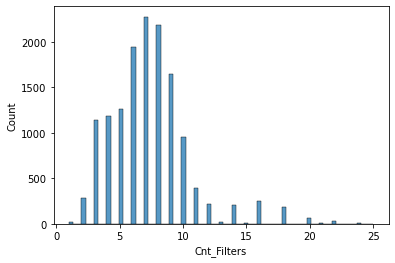

In [25]:
sns.histplot(data=final_df, x='Cnt_Filters')

In [26]:
final_df['Cnt_Filters'].describe()

count    14304.000000
mean         7.322218
std          3.232014
min          1.000000
25%          5.000000
50%          7.000000
75%          9.000000
max         25.000000
Name: Cnt_Filters, dtype: float64

In [27]:
final_df.groupby('Cnt_Filters')['Code'].nunique()

Cnt_Filters
1.0       20
2.0      281
3.0     1137
4.0     1183
5.0     1263
6.0     1940
7.0     2276
8.0     2186
9.0     1642
10.0     959
11.0     398
12.0     215
13.0      25
14.0     212
15.0      14
16.0     250
17.0       4
18.0     181
20.0      63
21.0      15
22.0      27
24.0      12
25.0       1
Name: Code, dtype: int64

In [28]:
# Checking some random products and their filters
final_df[final_df['Cnt_Filters'] == 18]

,Code,Name,Img_Ext,Parent_Category,Top_Category,Parent_Category_Name,Category_Name,Cnt_Filters
22,0989072003,Tanktop aus Kaschmir,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,18.0
34,0997152001,Geripptes Strick-Tanktop,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,18.0
51,0978903004,Kurzes Tanktop,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,18.0
56,0978903001,Kurzes Tanktop,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,18.0
71,0978903003,Kurzes Tanktop,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,18.0
...,...,...,...,...,...,...,...,...
13927,0969291002,Gemusterte Windjacke,.jpg,368.0,Kids,Outdoor,Kids_Outdoor,18.0
13928,0967246001,Wasserabweisender Parka,.jpg,368.0,Kids,Outdoor,Kids_Outdoor,18.0
13960,0967113001,Wasserdichter Overall,.jpg,368.0,Kids,Outdoor,Kids_Outdoor,18.0
13962,1028319001,Wind- und wasserdichte Shellhose,.jpg,368.0,Kids,Outdoor,Kids_Outdoor,18.0


In [29]:
attributes[attributes['Code'] == '0989072003'].merge(filters, left_on='Filter_ID', right_index=True, how='left')

,Code,Filter_ID,Parent_Category,Filter_Name,Filter_Option
26,0989072003,31.0,0,Farbe,"[Beige, colorWithNames=beige_f5f5dc]"
95,0989072003,48.0,0,MUSTER,"[einfarbig, patterns=einfarbig]"
51,0989072003,62.0,0,Produkttyp,"[Top, productTypes=Top]"
8,0989072003,80.0,0,Style,"[Tanktop, clothingStyles=Tanktop]"
70,0989072003,92.0,0,Ausschnitt,"[Rundausschnitt, necklineStyles=Rundausschnitt]"
25,0989072003,99.0,0,Ärmellänge,"[Ärmellos, sleeveLengths=%C3%84rmellos]"
85,0989072003,103.0,0,Länge,"[Normale Länge, garmentLengths=Normale+L%C3%A4..."
106,0989072003,122.0,0,Anlass,"[Freizeit, contexts=Freizeit]"
4,0989072003,123.0,0,Anlass,"[Lounge, contexts=Lounge]"
14,0989072003,1976.0,17,Farbe,"[Beige, colorWithNames=beige_f5f5dc]"


### Preparing a DF with only the items in Final DF and their attributes

In [30]:
attribs = attributes[attributes['Code'].isin(final_df['Code'].unique())]

In [31]:
attribs = attributes.merge(filters, left_on='Filter_ID', right_index=True, how='left')

In [32]:
attribs.shape

(141147, 5)

In [33]:
attribs.head()

,Code,Filter_ID,Parent_Category,Filter_Name,Filter_Option
0,0979236026,31.0,0,Farbe,"[Beige, colorWithNames=beige_f5f5dc]"
1,1080623001,31.0,0,Farbe,"[Beige, colorWithNames=beige_f5f5dc]"
2,1000128007,31.0,0,Farbe,"[Beige, colorWithNames=beige_f5f5dc]"
3,1000128008,31.0,0,Farbe,"[Beige, colorWithNames=beige_f5f5dc]"
4,0903309006,31.0,0,Farbe,"[Beige, colorWithNames=beige_f5f5dc]"


### Checking unique filter names and associated count of filter options

In [34]:
attribs['Filter_Name'].nunique()

20

So, there are 20 unique filter names

In [35]:
attribs.dtypes

Code                object
Filter_ID          float64
Parent_Category      int64
Filter_Name         object
Filter_Option       object
dtype: object

In [36]:
attribs['Filter_Option_Txt'] = attribs.apply(lambda row: row['Filter_Option'][0], axis=1)

In [37]:
attribs['Filter_Name'].sort_values().unique()

array(['Absatzhöhe', 'Accessoirestil', 'Anlass', 'Ausschnitt', 'Bundhöhe',
       'Deckkraft', 'Farbe', 'Finish', 'Funktion', 'Hautton', 'Konzept',
       'Kragen', 'Länge', 'MUSTER', 'Passform', 'Produkttyp', 'Schuhstil',
       'Style', 'Ärmellänge', 'Ärmelstil'], dtype=object)

In [38]:
attribs.groupby('Filter_Name')['Filter_Option_Txt'].sample(2).values

array(['Ohne Absatz', 'Ohne Absatz', 'Bucket Hat', 'Bucket Hat',
       'Freizeit', 'Freizeit', 'Rundausschnitt', 'Rundausschnitt',
       'Hoher Bund', 'Normale Bundhöhe', 'Mittlere Deckkraft',
       'Mittlere Deckkraft', 'Lila', 'Schwarz', 'Natürliches Finish',
       'Mattes Finish', 'Schnelltrocknend', 'Schnelltrocknend',
       'Sehr heller Hautton', 'Mittlerer bis dunkler Hautton',
       'H&M BEAUTY', 'DIVIDED', 'Turn-down-Kragen', 'Turn-down-Kragen',
       'Lang', 'Lang', 'einfarbig', 'einfarbig', 'Oversize',
       'Super Skinny Fit', 'Cardigan', 'Jacke', 'Sneaker', 'Slip-on',
       'Kapuzenshirt', 'Steppjacke', 'Langarm', 'Kurzarm', 'Raglanärmel',
       'Volantärmel'], dtype=object)

In [39]:
eng_convert = dict(zip(list(['Absatzhöhe', 'Accessoirestil', 'Anlass', 'Ausschnitt', 'Bundhöhe',
       'Deckkraft', 'Farbe', 'Finish', 'Funktion', 'Hautton', 'Konzept',
       'Kragen', 'Länge', 'MUSTER', 'Passform', 'Produkttyp', 'Schuhstil',
       'Style', 'Ärmellänge', 'Ärmelstil']), list([x.title() for x in 
    ['heel height', 'accessory style', 'occasion', 'neckline', 'waist height', 'Opacity', 'Color', 'Finish', 'Function', 'Skin Tone', 'Concept', 'collar', 'length', 'pattern', 'fit', 'product type', 'shoe style', 'style', 'sleeve length', 'sleeve style']
])))

In [40]:
attribs['Filter_Name_Eng'] = attribs.apply(lambda row: eng_convert[row['Filter_Name']], axis=1)

In [41]:
unique_filters = attribs.groupby('Filter_Name_Eng')['Filter_Option_Txt'].nunique()
pd.DataFrame(unique_filters).rename(columns={'Filter_Option_Txt': 'Number_Of_Options_In_Filter'})

,Number_Of_Options_In_Filter
Filter_Name_Eng,
Accessory Style,43
Collar,13
Color,18
Concept,12
Finish,4
Fit,9
Function,9
Heel Height,3
Length,10


### Checking some values for each filter to decide to keep / discard

In [42]:
uniq_filters_df = []

for idx, val in unique_filters.iteritems():
    # get a sample of values
    uniq_filters_df.append([
        idx, 
        attribs[attribs['Filter_Name_Eng'] == idx]['Filter_Option_Txt'].sample(min(val, 5)).values
    ])
    
uniq_filters_df = pd.DataFrame(uniq_filters_df, columns=['Filter_Name_Eng', 'Samples'])
uniq_filters_df

,Filter_Name_Eng,Samples
0,Accessory Style,"[Baseballcap, Baseballcap, Sonnenhut, Gliederk..."
1,Collar,"[Stehkragen, Turn-down-Kragen, Bubikragen, Ste..."
2,Color,"[Weiß, Grün, Grün, Weiß, Blau]"
3,Concept,"[DENIM, BASICS, H&M BEAUTY, EVERYDAY FASHION, ..."
4,Finish,"[Glänzendes Finish, Glänzendes Finish, Strahle..."
5,Fit,"[Slim Fit, Oversize, Regular Fit, Figurbetont,..."
6,Function,"[Schnelltrocknend, Schnelltrocknend, Reflektor..."
7,Heel Height,"[Ohne Absatz, Ohne Absatz, Niedriger Absatz]"
8,Length,"[Normale Länge, Normale Länge, Lang, Lang, Cro..."
9,Neckline,"[Rundausschnitt, Rundausschnitt, Tiefer Aussch..."


### Deciding to keep all filter options => Final outcomes will depend on accuracy per filter option

### Creating final DF -> Code, List of filters (one hot encoded) that apply to category, List of filters (ohe) that are available for product, List of Lists (ohe) having relevant values for filters that are available

In [43]:
df_filters = final_df.copy()

In [44]:
df_filters.shape

(14456, 8)

In [45]:
df_filters.drop(columns=['Cnt_Filters'], inplace=True)

In [46]:
filter_names = attribs['Filter_Name_Eng'].sort_values().unique()

Adding "Category_Filters" => One hot encoded list of filters available on the category level

In [47]:
all_filters = attribs[['Parent_Category', 'Filter_Name_Eng']].drop_duplicates(ignore_index=True)

In [48]:
all_filters['Val'] = 1

In [49]:
all_filters = all_filters.pivot(index='Parent_Category', columns='Filter_Name_Eng', values='Val').fillna(0).reset_index()

In [50]:
len(all_filters[filter_names].values.tolist())

52

In [51]:
filter_names

array(['Accessory Style', 'Collar', 'Color', 'Concept', 'Finish', 'Fit',
       'Function', 'Heel Height', 'Length', 'Neckline', 'Occasion',
       'Opacity', 'Pattern', 'Product Type', 'Shoe Style', 'Skin Tone',
       'Sleeve Length', 'Sleeve Style', 'Style', 'Waist Height'],
      dtype=object)

In [52]:
all_filters[filter_names].sum(axis=0)

Filter_Name_Eng
Accessory Style     9.0
Collar             28.0
Color              52.0
Concept            36.0
Finish              1.0
Fit                34.0
Function           31.0
Heel Height         8.0
Length             41.0
Neckline           31.0
Occasion           42.0
Opacity             1.0
Pattern            48.0
Product Type       45.0
Shoe Style          8.0
Skin Tone           1.0
Sleeve Length      35.0
Sleeve Style       23.0
Style              43.0
Waist Height       24.0
dtype: float64

In [53]:
all_filters['Filters'] = all_filters[filter_names].values.tolist()

In [54]:
df_filters = df_filters.merge(all_filters[['Parent_Category', 'Filters']], on='Parent_Category', how='left').rename(columns={'Filters': 'Category_Filters'})

In [55]:
df_filters

,Code,Name,Img_Ext,Parent_Category,Top_Category,Parent_Category_Name,Category_Name,Category_Filters
0,1071498001,Cut-out-Shirt,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ..."
1,1069183001,Kurzes Shirt mit Cut-out,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ..."
2,1069183002,Kurzes Shirt mit Cut-out,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ..."
3,1021919001,Pullover mit Cut-outs,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ..."
4,1062813001,Tanktop,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ..."
...,...,...,...,...,...,...,...,...
14451,0897909012,Weiche Hausschuhe,.jpg,370.0,Kids,Schuhe,Kids_Schuhe,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ..."
14452,1033466002,Weiche Hausschuhe mit Applikationen,.jpg,370.0,Kids,Schuhe,Kids_Schuhe,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ..."
14453,0897909013,Weiche Hausschuhe,.jpg,370.0,Kids,Schuhe,Kids_Schuhe,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ..."
14454,0897909011,Weiche Hausschuhe,.jpg,370.0,Kids,Schuhe,Kids_Schuhe,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ..."


In [518]:
# # check how many products have count of filters less than, same or greater than sum of fitlers
# df_filters.apply(lambda row: 
#                  1 if np.sum(row['Category_Filters']) > row['Cnt_Filters'] 
#                  else -1 if np.sum(row['Category_Filters']) < row['Cnt_Filters'] else 0, axis=1).value_counts()

# # -1 => Nr of filters on a product are more than the filters on the category
# # 0 => Nr of filters on a product are same as those expected on the category
# # 1 => Nr of filters on a product are less than the filters on the category

Adding "Product_Filters" => One hot encoded list of filters available on the product level

In [56]:
p_filters = attribs[['Code', 'Parent_Category', 'Filter_Name_Eng']].drop_duplicates(ignore_index=True)

In [57]:
p_filters['Val'] = 1

In [58]:
p_filters = p_filters.pivot(index=['Code', 'Parent_Category'], columns='Filter_Name_Eng', values='Val').fillna(0).reset_index()

In [59]:
len(p_filters[filter_names].values.tolist())

20244

In [60]:
p_filters[filter_names].sum(axis=0)

Filter_Name_Eng
Accessory Style      632.0
Collar              1678.0
Color              20216.0
Concept             8062.0
Finish               200.0
Fit                 4434.0
Function            1027.0
Heel Height          672.0
Length             13254.0
Neckline            6086.0
Occasion            8357.0
Opacity              160.0
Pattern            14934.0
Product Type       19094.0
Shoe Style           660.0
Skin Tone            150.0
Sleeve Length      10449.0
Sleeve Style         699.0
Style               8350.0
Waist Height        4725.0
dtype: float64

In [61]:
p_filters['Filters'] = p_filters[filter_names].values.tolist()

In [525]:
# df_filters.drop(columns=['Product_Filters'], inplace=True)

In [62]:
df_filters = df_filters.merge(p_filters[['Code', 'Parent_Category', 'Filters']], on=['Code', 'Parent_Category'], how='left').rename(columns={'Filters': 'Product_Filters'})

In [527]:
# # check how many products have count of filters less than, same or greater than sum of fitlers
# df_filters.apply(lambda row: 
#                  1 if np.sum(row['Product_Filters']) > row['Cnt_Filters'] 
#                  else -1 if np.sum(row['Product_Filters']) < row['Cnt_Filters'] else 0, axis=1).value_counts()

# # -1 => Nr of filters on a product are more than the filters on the category
# # 0 => Nr of filters on a product are same as those expected on the category
# # 1 => Nr of filters on a product are less than the filters on the category

In [63]:
# check how many products have count of filters less than, same or greater than sum of fitlers
df_filters.apply(lambda row: 
                 1 if np.sum(row['Category_Filters']) > np.sum(row['Product_Filters']) 
                 else -1 if np.sum(row['Category_Filters']) < np.sum(row['Product_Filters']) else 0, axis=1).value_counts()

# -1 => Nr of filters on a category are more than the filters on the product
# 0 => Nr of filters on a category are same as those on the product
# 1 => Nr of filters on a category are less than the filters on the product

1    13935
0      521
dtype: int64

In [64]:
df_filters.shape

(14456, 9)

Adding one hot encoded vectors for each filter option

In [65]:
attribs['Filter_Value'] = attribs.apply(lambda row: f"{row['Filter_Name_Eng']}_{row['Filter_Option_Txt']}", axis=1)

In [66]:
attribs

,Code,Filter_ID,Parent_Category,Filter_Name,Filter_Option,Filter_Option_Txt,Filter_Name_Eng,Filter_Value
0,0979236026,31.0,0,Farbe,"[Beige, colorWithNames=beige_f5f5dc]",Beige,Color,Color_Beige
1,1080623001,31.0,0,Farbe,"[Beige, colorWithNames=beige_f5f5dc]",Beige,Color,Color_Beige
2,1000128007,31.0,0,Farbe,"[Beige, colorWithNames=beige_f5f5dc]",Beige,Color,Color_Beige
3,1000128008,31.0,0,Farbe,"[Beige, colorWithNames=beige_f5f5dc]",Beige,Color,Color_Beige
4,0903309006,31.0,0,Farbe,"[Beige, colorWithNames=beige_f5f5dc]",Beige,Color,Color_Beige
...,...,...,...,...,...,...,...,...
166,0867741006,6732.0,372,Anlass,"[Sport, contexts=Sport]",Sport,Occasion,Occasion_Sport
167,0706020018,6732.0,372,Anlass,"[Sport, contexts=Sport]",Sport,Occasion,Occasion_Sport
168,1021159001,6732.0,372,Anlass,"[Sport, contexts=Sport]",Sport,Occasion,Occasion_Sport
169,0929864004,6732.0,372,Anlass,"[Sport, contexts=Sport]",Sport,Occasion,Occasion_Sport


In [67]:
final_filters = pd.DataFrame(df_filters['Code'].unique().copy())
final_filters.columns = ['Code']
final_filters.head()

,Code
0,1071498001
1,1069183001
2,1069183002
3,1021919001
4,1062813001


In [68]:
final_filters.shape

(14456, 1)

In [69]:
# select only those codes which are also there in final file
attribs = attribs[attribs['Code'].isin(final_filters['Code'].values)]

In [70]:
attribs['Filter_Value'].nunique()

466

In [71]:
filter_value_lists = []

In [72]:
for f in filter_names:
    filter_temp = pd.get_dummies(
            data=attribs[attribs['Filter_Name_Eng'] == f][['Code', 'Filter_Value']], 
            columns=['Filter_Value'],
            prefix='',
            prefix_sep=''
        )
    break

In [74]:
filter_temp = filter_temp.groupby('Code').sum()

In [537]:
for f in filter_names:
    filter_temp = pd.get_dummies(
        data=attribs[attribs['Filter_Name_Eng'] == f][['Code', 'Filter_Value']], 
        columns=['Filter_Value'],
        prefix='',
        prefix_sep=''
    )
    # get all unique codes with multi-labels
    filter_temp = filter_temp.groupby('Code').sum()
    # add the values to a list - we'll need this later when we're doing predictions
    filter_value_lists.append(filter_temp.columns.tolist())
    # compressing all codes into a list
    filter_temp[f] = filter_temp.values.tolist()
    # keeping only the code and the list
    filter_temp = filter_temp[f].reset_index()
    # merging the list back into the master df
    final_filters = final_filters.merge(filter_temp, on='Code', how='left')
    # setting all null values to an empty list
    final_filters[f] = final_filters[f].apply(lambda d: d if isinstance(d, list) else [])

# filter_temp.head()
final_filters.head()

,Code,Accessory Style,Collar,Color,Concept,Finish,Fit,Function,Heel Height,Length,...,Occasion,Opacity,Pattern,Product Type,Shoe Style,Skin Tone,Sleeve Length,Sleeve Style,Style,Waist Height
0,1071498001,[],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",[],"[1, 0, 0, 0, 0, 0, 0, 0, 0]",[],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",...,"[0, 0, 1, 0, 0, 0, 0, 0, 0]",[],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],[],"[0, 0, 0, 1, 0]",[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[]
1,1069183001,[],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",[],[],[],[],"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",...,"[0, 0, 1, 0, 0, 0, 0, 0, 0]",[],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],[],"[0, 0, 0, 1, 0]",[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[]
2,1069183002,[],[],"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",[],[],[],[],"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",...,"[0, 0, 1, 0, 0, 0, 0, 0, 0]",[],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],[],"[0, 0, 0, 1, 0]",[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[]
3,1021919001,[],"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]",[],[],[],[],"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]",...,"[0, 0, 1, 0, 0, 0, 0, 0, 0]",[],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],[],"[0, 0, 0, 1, 0]",[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[]
4,1062813001,[],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",[],"[1, 0, 0, 0, 0, 0, 0, 0, 0]",[],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",...,"[0, 0, 1, 0, 0, 0, 0, 0, 0]",[],"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],[],"[0, 0, 0, 0, 1]",[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[]


In [538]:
final_filters.shape

(14456, 21)

In [539]:
final_filters.isna().sum()

Code               0
Accessory Style    0
Collar             0
Color              0
Concept            0
Finish             0
Fit                0
Function           0
Heel Height        0
Length             0
Neckline           0
Occasion           0
Opacity            0
Pattern            0
Product Type       0
Shoe Style         0
Skin Tone          0
Sleeve Length      0
Sleeve Style       0
Style              0
Waist Height       0
dtype: int64

In [540]:
final_filters['Filter_Values'] = final_filters[filter_names].values.tolist()

In [541]:
final_filters[['Code', 'Filter_Values']].head()

,Code,Filter_Values
0,1071498001,"[[], [], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1069183001,"[[], [], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1069183002,"[[], [], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,1021919001,"[[], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], ..."
4,1062813001,"[[], [], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [542]:
final_filters.shape

(14456, 22)

In [543]:
df_filters.shape

(14456, 9)

In [544]:
df_filters = df_filters.merge(final_filters[['Code', 'Filter_Values']], on='Code', how='left')

In [545]:
df_filters.head()

,Code,Name,Img_Ext,Parent_Category,Top_Category,Parent_Category_Name,Category_Name,Category_Filters,Product_Filters,Filter_Values
0,1071498001,Cut-out-Shirt,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...","[[], [], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1069183001,Kurzes Shirt mit Cut-out,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[], [], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1069183002,Kurzes Shirt mit Cut-out,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[], [], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,1021919001,Pullover mit Cut-outs,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], ..."
4,1062813001,Tanktop,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...","[[], [], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [546]:
df_filters.shape

(14456, 10)

In [547]:
filter_value_lists

[['Accessory Style_Armband mit Anhängern',
  'Accessory Style_Armkette',
  'Accessory Style_Babyhaube',
  'Accessory Style_Baker-Boy-Mütze',
  'Accessory Style_Balaclava',
  'Accessory Style_Baseballcap',
  'Accessory Style_Bucket Hat',
  'Accessory Style_Cap mit Ohrenklappen',
  'Accessory Style_Crossbody-Tasche',
  'Accessory Style_Earcuff',
  'Accessory Style_Fedora-Hut',
  'Accessory Style_Flaschentasche',
  'Accessory Style_Gliederkette',
  'Accessory Style_Handschuhe für Kinderwagen',
  'Accessory Style_Handtasche',
  'Accessory Style_Hobotasche',
  'Accessory Style_Hüfttasche',
  'Accessory Style_Kette mit Anhänger',
  'Accessory Style_Laptoptasche',
  'Accessory Style_Manschettenarmreif',
  'Accessory Style_Mehrreihige Halskette',
  'Accessory Style_Mehrreihiges Armband',
  'Accessory Style_Ohrhänger',
  'Accessory Style_Ohrstecker',
  'Accessory Style_Pouch',
  'Accessory Style_Rolltop-Rucksack',
  'Accessory Style_Rucksack',
  'Accessory Style_Runde Ohrringe',
  'Accessory St

In [548]:
# saving the filters file
df_filters.to_parquet(hnm_file_format.format('Final_Input_Filters'))

In [550]:
# save the list files as a pickle file
with open('data/HnM_FilterValueLists.pkl', 'wb') as file_pi:
    pickle.dump(filter_value_lists, file_pi)